**TASI-2223-114 FAKE NEWS DETECTION**

*   12S19014 Kartika Lidya Rotua Sianipar
*   12S19039 Anugerah Salomo Rafael Simanjuntak
*   12S19059 Rut Yana Gultom




# Load data and Preprocesing


Source yang digunakan:


*   [Source code untuk BERT](https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=86C9objaKu8f)

*   [Source de untuk preprocessing](https://ksnugroho.medium.com/dasar-text-preprocessing-dengan-python-a4fa52608ffe)



## **1. Cek resource**

In [1]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 25.2 MB/s eta 0:00:00


In [3]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=0b6d5e9ec345b94e44244ae7efe63edbb5f7c16eb7a596a316d38e72bd54ce53
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


## **2. Download & load dataset**

In [4]:
import pandas as pd

df = pd.read_csv("/content/sample_data/turnbackhoax (1) (1) (1).csv") #delimiter='\t'
df.shape

(1118, 3)

In [5]:
df.sample(5)

,Label,Headline,Body
958,0.0,"PM Cina Peringatkan Indonesia, Jika Tragedi 9...",SUMBER : MEDIA SOSIAL NARASI : “PM Cina Pering...
316,1.0,Klarifikasi Video Kapolres Landak AKBP Bowo Ge...,"“Perlu kita tahu saudara-saudaraku, bahwa Kapo..."
312,1.0,Klarifikasi Twitter Tentang Tuduhan Tak Netral...,Twitter Indonesia melalui @TwitterID dan laman...
168,1.0,DITUDING TAWARKAN PEKERJAAN KE PERETAS SITUS K...,[ Postingan ini berisi klarifikasi dari pihak ...
913,0.0,Minum Air Es Sebabkan Sakit Jantung,SUMBER : Pesan Berantai Whatsapp dan media NAR...


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'samples')

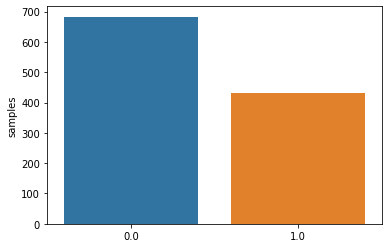

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

x=df.Label.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

In [7]:
body = df.Body.values
headline = df.Headline.values
labels = df.Label.values  

##**3. Preprocessing data**

###CLEANING DATASET

Kami menggunakan Python Sastrawi yang merupakan pengembangan dari proyek PHP Sastrawi. Python Sastrawi merupakan library sederhana yang dapat mengubah kata berimbuhan bahasa Indonesia menjadi bentuk dasarnya. 
https://github.com/har07/PySastrawi

####Delete Null

In [8]:
print(df.isnull().values.any())

True


In [9]:
df.isnull().sum()

Label       2
Headline    2
Body        4
dtype: int64

In [10]:
df.isna().sum()

Label       2
Headline    2
Body        4
dtype: int64

In [11]:
print("Cek Missing Value:\n" ,df.isnull().any())
df.isnull().sum()

Cek Missing Value:
 Label       True
Headline    True
Body        True
dtype: bool


Label       2
Headline    2
Body        4
dtype: int64

In [12]:
data = df[df['Label'].notna()]
data = df[df['Headline'].notna()]
data = df[df['Body'].notna()]

In [13]:
data.isnull().sum()

Label       0
Headline    0
Body        0
dtype: int64

In [14]:
data.dropna

<bound method DataFrame.dropna of       Label                                           Headline  \
0       1.0  Pertamina dan Pemerintah Kalrifikasi Isu BBM N...   
1       1.0  Polda Nusa Tenggara Barat Mengklarifkasi Bahwa...   
2       1.0  PT Ultrajaya Milk Industry Tbk Mengklarifikasi...   
3       1.0  BBKSDA Jatim Mengklarifikasi Bahwa Wisata Alam...   
4       1.0  BMKG Mataram Menghimbau Agar Warga Tidak Langs...   
...     ...                                                ...   
1113    0.0   Vaksin Kanker Serviks Menyebabkan Menopause Dini   
1114    0.0  Video Cindera Mata Raja Salman Untuk Ibu Irian...   
1115    0.0  Video Simulasi Hacking Manipulasi Suara Pilgub...   
1116    0.0  Website KPU Gampang Jebol Karena Scriptnya Tel...   
1117    0.0             Yang Benci FPI Ada Lima (Foto Gus Mus)   

                                                   Body  
0     Foto: Kumparan.com Debunk ini berisi iKlarifik...  
1     Foto Ilustrasi Perkosaan Debunk ini berisi kla...  

In [15]:
data

,Label,Headline,Body
0,1.0,Pertamina dan Pemerintah Kalrifikasi Isu BBM N...,Foto: Kumparan.com Debunk ini berisi iKlarifik...
1,1.0,Polda Nusa Tenggara Barat Mengklarifkasi Bahwa...,Foto Ilustrasi Perkosaan Debunk ini berisi kla...
2,1.0,PT Ultrajaya Milk Industry Tbk Mengklarifikasi...,Debunk ini berisi klarifikasi dari PT Ultrajay...
3,1.0,BBKSDA Jatim Mengklarifikasi Bahwa Wisata Alam...,foto: tribunnews.com Debunk ini berisi Klrifik...
4,1.0,BMKG Mataram Menghimbau Agar Warga Tidak Langs...,Foto: tribunnews.com (Jokowi sedang memantau l...
...,...,...,...
1113,0.0,Vaksin Kanker Serviks Menyebabkan Menopause Dini,HOAX: Vaksin kanker serviks pada anak-anak SD ...
1114,0.0,Video Cindera Mata Raja Salman Untuk Ibu Irian...,Sebuah akun Twitter dengan nama akun @gerilyap...
1115,0.0,Video Simulasi Hacking Manipulasi Suara Pilgub...,Sebuah akun Facebook memposting video yang dia...
1116,0.0,Website KPU Gampang Jebol Karena Scriptnya Tel...,Sebuah akun Facebook memposting status yang me...


####Hapus tanda baca

In [16]:
import numpy as np

In [17]:
symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
data['Body'] = data['Body'].str.translate({ord(symbol):"" for symbol in symbols})

<ipython-input-17-46e38b0c7099>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Body'] = data['Body'].str.translate({ord(symbol):"" for symbol in symbols})


In [18]:
data['Headline'] = data['Headline'].str.translate({ord(symbol):"" for symbol in symbols})

<ipython-input-18-c6c3b6151699>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Headline'] = data['Headline'].str.translate({ord(symbol):"" for symbol in symbols})


In [19]:
data

,Label,Headline,Body
0,1.0,Pertamina dan Pemerintah Kalrifikasi Isu BBM N...,Foto Kumparancom Debunk ini berisi iKlarifikas...
1,1.0,Polda Nusa Tenggara Barat Mengklarifkasi Bahwa...,Foto Ilustrasi Perkosaan Debunk ini berisi kla...
2,1.0,PT Ultrajaya Milk Industry Tbk Mengklarifikasi...,Debunk ini berisi klarifikasi dari PT Ultrajay...
3,1.0,BBKSDA Jatim Mengklarifikasi Bahwa Wisata Alam...,foto tribunnewscom Debunk ini berisi Klrifikas...
4,1.0,BMKG Mataram Menghimbau Agar Warga Tidak Langs...,Foto tribunnewscom Jokowi sedang memantau loka...
...,...,...,...
1113,0.0,Vaksin Kanker Serviks Menyebabkan Menopause Dini,HOAX Vaksin kanker serviks pada anakanak SD ak...
1114,0.0,Video Cindera Mata Raja Salman Untuk Ibu Irian...,Sebuah akun Twitter dengan nama akun gerilyapo...
1115,0.0,Video Simulasi Hacking Manipulasi Suara Pilgub...,Sebuah akun Facebook memposting video yang dia...
1116,0.0,Website KPU Gampang Jebol Karena Scriptnya Tel...,Sebuah akun Facebook memposting status yang me...


####Case folding

In [20]:
data['Body'] = data['Body'].str.lower()

<ipython-input-20-3821a40779b1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Body'] = data['Body'].str.lower()


In [21]:
data['Headline'] = data['Headline'].str.lower()

<ipython-input-21-4f59d2d3d152>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Headline'] = data['Headline'].str.lower()


In [22]:
data

,Label,Headline,Body
0,1.0,pertamina dan pemerintah kalrifikasi isu bbm n...,foto kumparancom debunk ini berisi iklarifikas...
1,1.0,polda nusa tenggara barat mengklarifkasi bahwa...,foto ilustrasi perkosaan debunk ini berisi kla...
2,1.0,pt ultrajaya milk industry tbk mengklarifikasi...,debunk ini berisi klarifikasi dari pt ultrajay...
3,1.0,bbksda jatim mengklarifikasi bahwa wisata alam...,foto tribunnewscom debunk ini berisi klrifikas...
4,1.0,bmkg mataram menghimbau agar warga tidak langs...,foto tribunnewscom jokowi sedang memantau loka...
...,...,...,...
1113,0.0,vaksin kanker serviks menyebabkan menopause dini,hoax vaksin kanker serviks pada anakanak sd ak...
1114,0.0,video cindera mata raja salman untuk ibu irian...,sebuah akun twitter dengan nama akun gerilyapo...
1115,0.0,video simulasi hacking manipulasi suara pilgub...,sebuah akun facebook memposting video yang dia...
1116,0.0,website kpu gampang jebol karena scriptnya tel...,sebuah akun facebook memposting status yang me...


####Stopword Removal

In [23]:
pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 KB 9.8 MB/s eta 0:00:00


In [24]:
import re

In [25]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()
print(stopwords)

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'ingin', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', '

In [26]:
stopwords.remove('tidak')

In [27]:
print(stopwords)

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'ingin', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', 'oh', 'ok'

In [28]:
stopwords.sort()

# print vowels
for i in stopwords:
  print(i)

ada
adalah
agak
agar
akan
amat
anda
antara
anu
apakah
apalagi
atau
bagaimanapun
bagi
bahwa
begitu
belum
bisa
boleh
dahulu
dalam
dan
dapat
dari
daripada
demi
demikian
dengan
di
dia
dimana
dll
dsb
dst
dua
dulunya
guna
hal
hanya
harus
ia
ingin
ini
itu
itulah
jika
jika
juga
juga
kah
kami
karena
ke
kecuali
kemana
kembali
kenapa
kepada
ketika
kita
lagi
lain
maka
mari
masih
melainkan
mengapa
menurut
mereka
namun
nanti
nggak
oh
ok
oleh
pada
para
pasti
pula
pun
saat
saja
sambil
sampai
saya
sebab
sebagai
sebelum
sebetulnya
secara
sedangkan
seharusnya
sehingga
sekitar
selagi
selain
sementara
sementara
seolah
seperti
seraya
serta
sesuatu
sesudah
setelah
seterusnya
setiap
setidaknya
sudah
supaya
tanpa
tapi
telah
tentang
tentu
terhadap
tetapi
toh
tolong
untuk
walau
ya
yaitu
yakni
yang


In [48]:
clean_data=data
print(clean_data)

      Label                                           Headline  \
0       1.0  pertamina dan pemerintah kalrifikasi isu bbm n...   
1       1.0  polda nusa tenggara barat mengklarifkasi bahwa...   
2       1.0  pt ultrajaya milk industry tbk mengklarifikasi...   
3       1.0  bbksda jatim mengklarifikasi bahwa wisata alam...   
4       1.0  bmkg mataram menghimbau agar warga tidak langs...   
...     ...                                                ...   
1113    0.0   vaksin kanker serviks menyebabkan menopause dini   
1114    0.0  video cindera mata raja salman untuk ibu irian...   
1115    0.0  video simulasi hacking manipulasi suara pilgub...   
1116    0.0  website kpu gampang jebol karena scriptnya tel...   
1117    0.0               yang benci fpi ada lima foto gus mus   

                                                   Body  
0     foto kumparancom debunk ini berisi iklarifikas...  
1     foto ilustrasi perkosaan debunk ini berisi kla...  
2     debunk ini berisi klarifika

In [59]:
def remove_stopwords(stopwords):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(stopwords).split() if word not in stopwords])

clean_data1 = clean_data.apply(lambda text: remove_stopwords(stopwords))
clean_data1

Label       ['ada', 'adalah', 'agak', 'agar', 'akan', 'ama...
Headline    ['ada', 'adalah', 'agak', 'agar', 'akan', 'ama...
Body        ['ada', 'adalah', 'agak', 'agar', 'akan', 'ama...
dtype: object

In [60]:
clean_data.remove(clean_data1)

AttributeError: ignored

In [56]:
# import re
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# factory = StemmerFactory()
# stemmer = factory.create_stemmer()

def remove_stopword(clean_data):
    clean_data = ' '.join(['' if stopwords in clean_data else stopwords for clean_data in clean_data.split(' ')])
    clean_data = re.sub('  +', ' ', clean_data) # Remove extra spaces
    clean_data = clean_data.strip()
    return clean_data

print(clean_data)

      Label                                           Headline  \
0       1.0  pertamina dan pemerintah kalrifikasi isu bbm n...   
1       1.0  polda nusa tenggara barat mengklarifkasi bahwa...   
2       1.0  pt ultrajaya milk industry tbk mengklarifikasi...   
3       1.0  bbksda jatim mengklarifikasi bahwa wisata alam...   
4       1.0  bmkg mataram menghimbau agar warga tidak langs...   
...     ...                                                ...   
1113    0.0   vaksin kanker serviks menyebabkan menopause dini   
1114    0.0  video cindera mata raja salman untuk ibu irian...   
1115    0.0  video simulasi hacking manipulasi suara pilgub...   
1116    0.0  website kpu gampang jebol karena scriptnya tel...   
1117    0.0               yang benci fpi ada lima foto gus mus   

                                                   Body  
0     foto kumparancom debunk ini berisi iklarifikas...  
1     foto ilustrasi perkosaan debunk ini berisi kla...  
2     debunk ini berisi klarifika

In [ ]:
# from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
# import pandas as pd

# factory = StopWordRemoverFactory()
# stopword = factory.create_stop_word_remover()

# # df = pd.read_csv("kalimat.csv")
# # for i, text in enumerate (text):
# for i, stopwords in text.split(' '):
#     stop = stopwords.remove(text)
#     print(i,stop + '\n')

####Load BERT Tokenizer

In [ ]:
from transformers import BertTokenizer

print("Loading BERT Tokenizer")
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

In [ ]:
df.sample(5)

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in body:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        str(sent),                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', body[0])
print('Token IDs:', input_ids[0])

In [ ]:
print('Original: ', body[0:5])
print('Token IDs:', input_ids[0:5])

In [ ]:
print("Original: ", body[0])

print("Tokenized: ", tokenizer.tokenize(body[0]))

print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(body[0])))